In [2]:
from jax import config

config.update("jax_enable_x64", True)

import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import NestedSampler
from jaxns import Model
from jaxns import Prior
from jaxns import bruteforce_evidence
from jaxns.framework.special_priors import ForcedIdentifiability
tfpd = tfp.distributions

In [5]:

def log_likelihood(theta):
    def log_circ(theta, c, r, w):
        return -0.5 * (jnp.linalg.norm(theta - c) - r) ** 2 / w ** 2 - jnp.log(jnp.sqrt(2 * jnp.pi * w ** 2))

    w1 = w2 = jnp.array(0.1)
    r1 = r2 = jnp.array(2.)
    c1 = jnp.array([0., -3.])
    c2 = jnp.array([0., 3.])
    return jnp.logaddexp(log_circ(theta, c1, r1, w1), log_circ(theta, c2, r2, w2))



def prior_model():
    x = yield ForcedIdentifiability(n=2, low=-6, high=6, name='x')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)
model.sanity_check(key=random.PRNGKey(0),S=100)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [6]:
exact_ns = NestedSampler(model=model, max_samples=1e5, k=0, s=5, c=model.U_ndims * 100)

termination_reason, state = exact_ns(random.PRNGKey(42))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)

In [7]:
exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 201258
samples: 2100
phantom samples: 0
likelihood evals / sample: 95.8
phantom fraction (%): 0.0%
--------
logZ=-1.55 +- 0.13
max(logL)=1.38
H=-2.44
ESS=215
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 0.0 +- 1.4 | -1.9 / 0.2 / 1.8 | 0.4 | 0.4
x[1]: 3.2 +- 1.4 | 1.1 / 3.4 / 4.9 | 5.0 | 5.0
--------


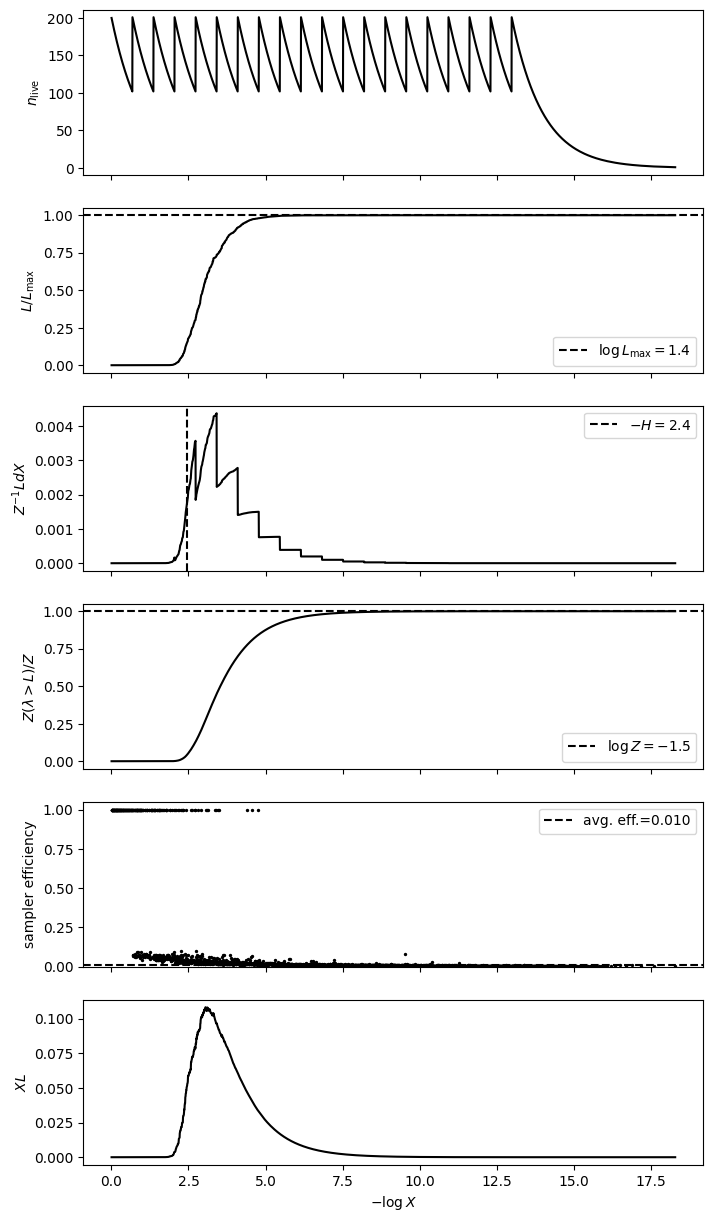

In [8]:
exact_ns.plot_diagnostics(results)

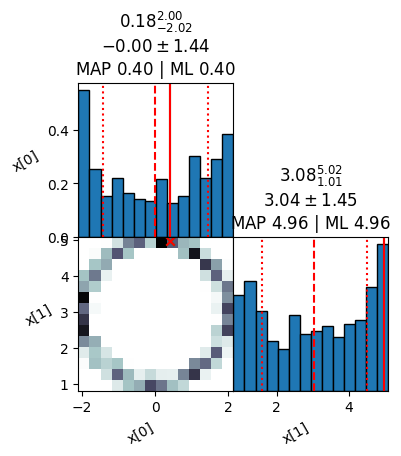

In [9]:
exact_ns.plot_cornerplot(results)

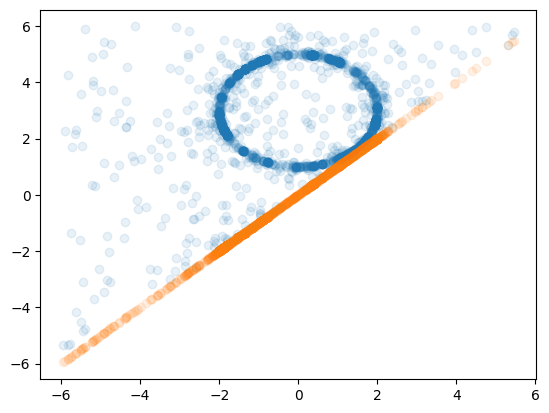

In [12]:
samples = results.samples['x']

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)
plt.scatter(samples[:, 0], samples[:, 0], alpha=0.1)
